In [1]:
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import skimage.io as io
import math
from PIL import Image
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.exposure import histogram, cumulative_distribution
from skimage import img_as_ubyte, img_as_float
from scipy.stats import norm
from copy import deepcopy

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (128, 128, 3)
Hight of the image 128
Width of the image 128
Dimension of the Image 3


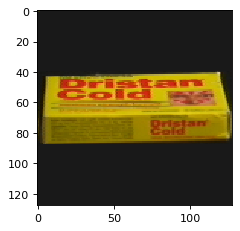

In [2]:
img = imread('archive/coil-100/coil-100/obj1__0.png')
plt.figure(num=None, figsize=(4, 3), dpi=80)
imshow(img)
#basic properties of image
print('Type of the image : ',type(img))
print('Shape of the image : {}'.format(img.shape))
print('Hight of the image {}'.format(img.shape[0]))
print('Width of the image {}'.format(img.shape[1]))
print('Dimension of the Image {}'.format(img.ndim)) 


We can see the shape of the image is three-layered and its width is 128, and the height of the image is 128. The type of image is an np array three-layered matrix.

In [3]:
#Check for the RGB values and size of the image
print('Image size {}'.format(img.size))
print('Maximum RGB value in this image {}'.format(img.max()))
print('Minimum RGB value in this image {}'.format(img.min())) 

Image size 49152
Maximum RGB value in this image 253
Minimum RGB value in this image 0


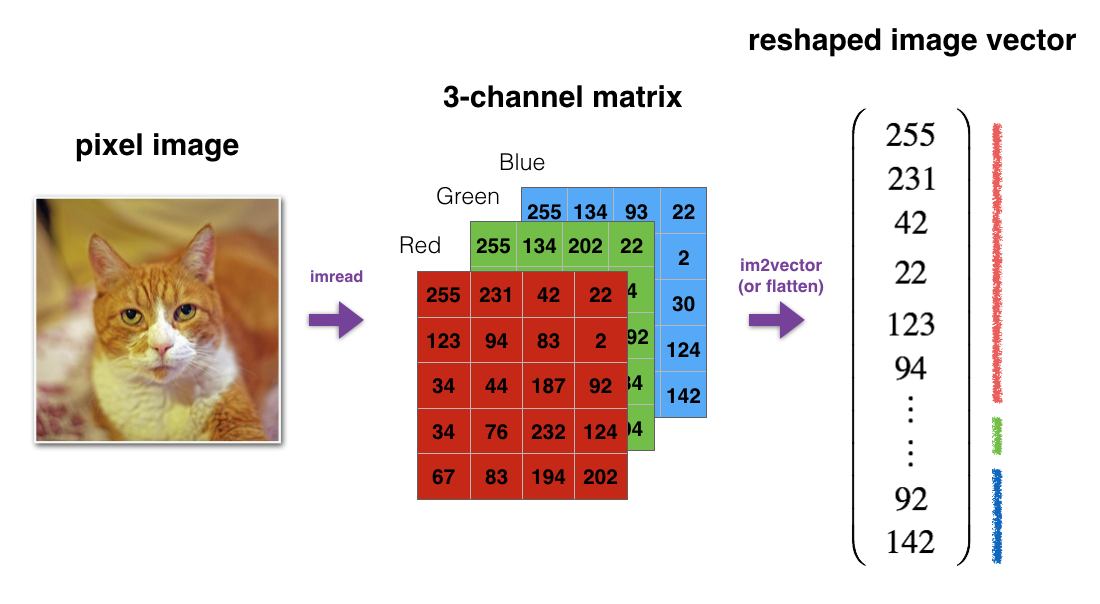

In [4]:
from IPython.display import Image
Image(filename='image2vector_kiank.png') 

In [72]:
import cv2
import numpy as np

# if image type is b g r, then b g r value will be displayed.
# if image is gray then color intensity will be displayed.
image = cv2.imread("archive/coil-100/coil-100/obj1__0.png") #open image
img_array = image #array des valeurs b,g,r de chaque pixels 
print(img_array.shape) # 3d array
print(type(img_array))
#print(img_array[0])

color = image[0][0] # valeurs b,g,r de pixel aux coordinates x =0, y=0
#print (color)
#print(img_array)

(128, 128, 3)
<class 'numpy.ndarray'>


In [51]:
#hight and width of the image
print(image.shape[0])
print(image.shape[1])

128
128


In [73]:
#opponent encoding
#rg = r - g
#by = 2*b -r - g
#wb = r + g + b
np.seterr(over='ignore')
#new_shape = np.zeros((image.shape[0], image.shape[1], 3))
new_shape = [[[0 for k in range(3)] for j in range(image.shape[1])] for i in range(image.shape[0])]
print(len(new_shape))
for i in range(len(img_array)):
    for j in range(len(img_array[i])):
        new_shape[i][j][0] = int(img_array[i][j][2] - img_array[i][j][1])
        new_shape[i][j][1] = int((2*img_array[j][i][0]) -img_array[i][j][2] - img_array[i][i][1])
        new_shape[i][j][2] = int(img_array[i][j][2] + img_array[i][j][1] + img_array[i][i][0])
new_shape = np.array(new_shape)
print(new_shape.shape)
#print(new_shape[0]) #tester premier pixel d'image avec rg,by,wb

128
(128, 128, 3)


In [76]:
#normalization rg,by,wb
normalized = [[[0 for k in range(3)] for j in range(image.shape[1])] for i in range(image.shape[0])]
for i in range(len(new_shape)):
    for j in range(len(new_shape[i])):
        normalized[i][j][0] = int(math.floor(((new_shape[i][j][0] + 255) *8) / 510))
        normalized[i][j][1] = int(math.floor(((new_shape[i][j][1] + 255) *16) / 510))
        normalized[i][j][2] = int(math.floor(((new_shape[i][j][2] + 255) *16) / 510))
normalized = np.array(normalized)
print(normalized.shape)
#print(normalized[0]) #tester premier pixel d'image avec rg,by,wb

(128, 128, 3)


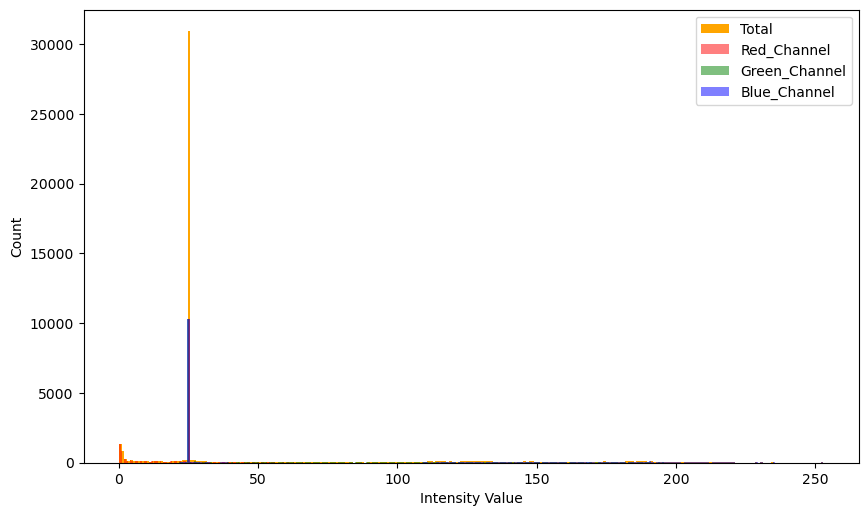

In [77]:
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=100)
#image = io.imread('~/Desktop/Lenna.png')
plt.hist(image.ravel(), bins = 256, color = 'orange', )
plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)

plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

In [93]:
hist = cv2.calcHist([normalized.astype(np.float32)], #image pixel values array
                    [0, 1, 2], #which channels do you (all RGB channels here)
                    None, #mask, not used in this
                    [8, 16, 16], # how many descriptors do you want per channel?
                    [0, 8, 0, 16, 0, 16] # what is the range of values per color channel?
                   )
features = cv2.normalize(hist, hist).flatten()

print(features.shape)
print(type(features))
print(features[0:100])

(2048,)
<class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
